<a href="https://colab.research.google.com/github/Kavya-sree/Hair-Type-Classifier/blob/main/Hair_type_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install -Uqq fastai

In [1]:
pip install Pillow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import fastai
fastai.__version__

'2.7.12'

In [5]:
from fastai.vision.all import *
from fastai.vision.widgets import *

In [6]:
hair_types = 'curly','straight','wavy','kinky'
path = Path('/content/drive/MyDrive/hair')

In [7]:
fns = get_image_files(path)
fns

(#1375) [Path('/content/drive/MyDrive/hair/Wavy/bca63af1e3e2f0bb8c97882ba035c087.jpg'),Path('/content/drive/MyDrive/hair/Wavy/cf02a85dc28657ea30b2927a998475f9.jpg'),Path('/content/drive/MyDrive/hair/Wavy/cbb045680aab22530c723e4a8fb7a3ec.jpg'),Path('/content/drive/MyDrive/hair/Wavy/ec577fcefe40fb8884a3c847a27f2055.jpg'),Path('/content/drive/MyDrive/hair/Wavy/aff604e1fa917e70564aa3e9b7bb78ce.jpg'),Path('/content/drive/MyDrive/hair/Wavy/34be707dfe1fb0e431b21764757a4e88.jpg'),Path('/content/drive/MyDrive/hair/Wavy/3534f6def9c33dfb98865cdd8210fd653.jpg'),Path('/content/drive/MyDrive/hair/Wavy/0837c1aa60868485923f00a96e7578853.jpg'),Path('/content/drive/MyDrive/hair/Wavy/edb78b0ecd23bab5160a753897676c594.jpg'),Path('/content/drive/MyDrive/hair/Wavy/78b1b28e92683bd97008b15a68c436a22.jpg')...]

## Data Loader
DataLoaders: A fastai class that stores multiple DataLoader objects you pass to it, normally a train and a valid, although it's possible to have as many as you like. The first two are made available as properties.

In [8]:
class DataLoaders(GetAttr):
    def __init__(self, *loaders): self.loaders = loaders
    def __getitem__(self, i): return self.loaders[i]
    train,valid = add_props(lambda i,self: self[i])

With `DataBlock` API you can fully customize every stage of the creation of your `DataLoaders`.

In [9]:
hair_type = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [10]:
dls = hair_type.dataloaders(path)

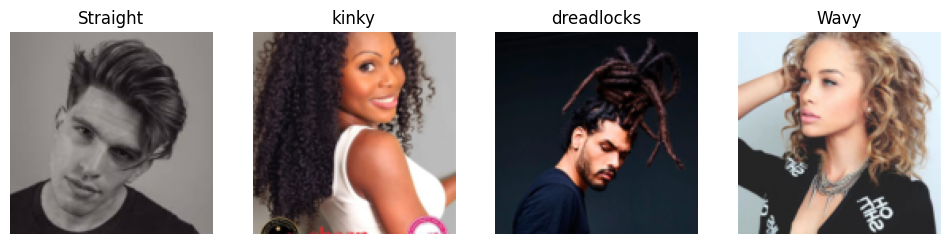

In [11]:
dls.valid.show_batch(max_n=4, nrows=1)

# Modelling

We don't have a lot of data for our problem, so to train our model, we'll use `RandomResizedCrop` with an image size of 224 px, which is fairly standard for image classification, and default aug_transforms:

In [12]:
hair = hair_type.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = hair.dataloaders(path)

In [13]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(5)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 72.4MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,1.762253,0.507126,0.178182,03:25


epoch,train_loss,valid_loss,error_rate,time
0,0.651905,0.308077,0.112727,04:16
1,0.557080,0.247051,0.076364,04:05
2,0.449840,0.196049,0.061818,04:13
3,0.356115,0.181368,0.047273,04:07
4,0.299351,0.180082,0.050909,04:12


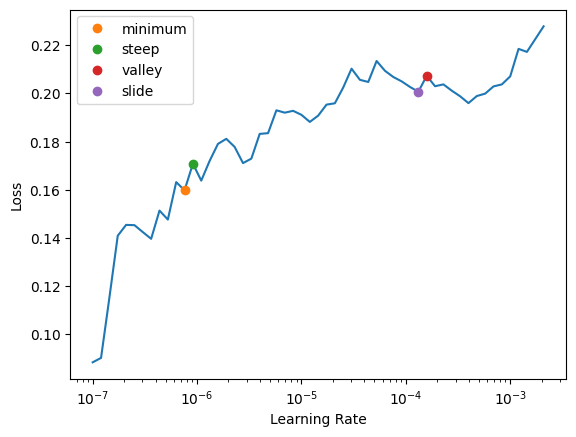

In [14]:
learn.save('stage-1')
learn.unfreeze()
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

In [15]:
learn.fit_one_cycle(10, lrs.valley)

epoch,train_loss,valid_loss,error_rate,time
0,0.196346,0.184234,0.061818,04:12
1,0.194389,0.193327,0.043636,04:14
2,0.220296,0.345188,0.116364,04:13
3,0.214748,0.331660,0.080000,04:06
4,0.196477,0.232053,0.080000,04:08
5,0.171940,0.206356,0.069091,04:10
6,0.150150,0.222132,0.065455,04:13
7,0.133312,0.220367,0.061818,04:06
8,0.118458,0.214746,0.069091,04:08
9,0.105885,0.212671,0.065455,04:12


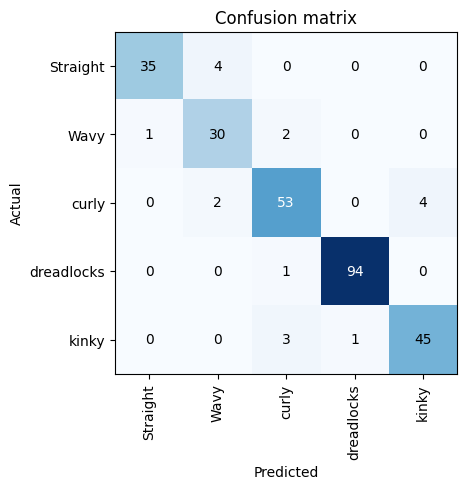

In [16]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

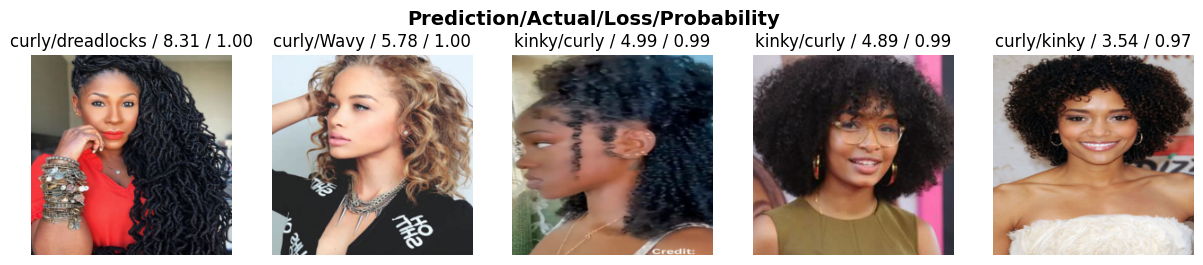

In [17]:
interp.plot_top_losses(5, nrows=1)

In [18]:
learn.export("hair-resnet18-model.pkl")